In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 

import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

In [57]:
common_years = [2006,2015]

#Get information from the shapefile

shape_file = '/Users/francesco/Desktop/squares.shp.gpkg'

ids = []
boundaries = []

# Open and extract boundaries
with fiona.open(shape_file, "r") as shapefile:
    for feature in shapefile:
        ids.append(int(feature['id'])) #id is registered as a string in the geometry file
        polygon = shape(feature['geometry'])
        bounds = polygon.bounds
        boundaries.append(bounds)

# Create a DataFrame with the information retrieved from the previous block
df = pd.DataFrame({'boundaries': boundaries}, index=ids)

# Sort the dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)

# Display the DataFrame
print(df)


                                          boundaries
1  (-1992484.4850636236, -693975.9218715788, -148...


In [46]:
#Load the masks
cnn_dataset_directory = '/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/'

ice_mask = np.load(cnn_dataset_directory + 'ice_mask.npy', allow_pickle=True)
land_mask = np.load(cnn_dataset_directory + 'land_mask.npy', allow_pickle=True)
sea_mask = np.load(cnn_dataset_directory + 'sea_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(cnn_dataset_directory + 'grounded_ice_mask.npy', allow_pickle=True)
boarders_mask = np.load(cnn_dataset_directory + 'boarders.npy', allow_pickle=True)

ice_mask = pd.DataFrame(ice_mask, index=df.index, columns=common_years)
land_mask = pd.DataFrame(land_mask, index=df.index, columns=common_years)
sea_mask = pd.DataFrame(sea_mask, index=df.index, columns=common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index=df.index, columns=common_years)
boarders_mask = pd.DataFrame(boarders_mask, index=df.index, columns=common_years)


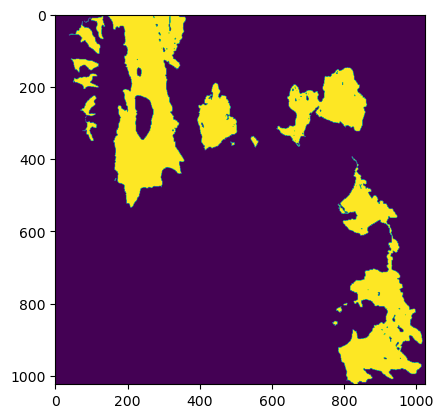

In [47]:
plt.imshow(ice_mask.loc[1,2015])

Now Basal Melting from Paolo dataset

In [48]:

root = '/Users/francesco/Desktop/Thesis/Data/GEOTIFFs/melt_' #Change in cluster
end = '_warp_ps.tif'

file_name_bm = []

for year in common_years:
    file_name_bm.append(root + str(year) + end)

# I need to open bed machine
bm = pd.DataFrame(index=ids, columns=common_years)
percentile_value = 30

for id in df.index:

    xmin, ymin, xmax, ymax = df['boundaries'].loc[id]

    for year in common_years:

        file_name = root + str(year) + end

        with rasterio.open(file_name, crs = 'EPSG:3031') as src:

            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform) #this is bm
            image = src.read(1, window=window) #this is bm in the window

            bm_tmp = np.zeros_like(image, dtype = float)
            bm_tmp = image

            percentile = np.percentile(bm_tmp[~np.isnan(bm_tmp)], percentile_value) #calculating percentile
            print(percentile)

             #filling the boarders with the percentile value
            bm_tmp[land_mask.loc[id, year]] = 0 #filling the land with nan
            bm_tmp[sea_mask.loc[id, year]] = 0
            bm_tmp[grounded_ice_mask.loc[id, year]] = 0
            bm_tmp[boarders_mask.loc[id, year]] = percentile

            bm.loc[id, year] = bm_tmp

-4.699886512756348
-2.5312609672546387


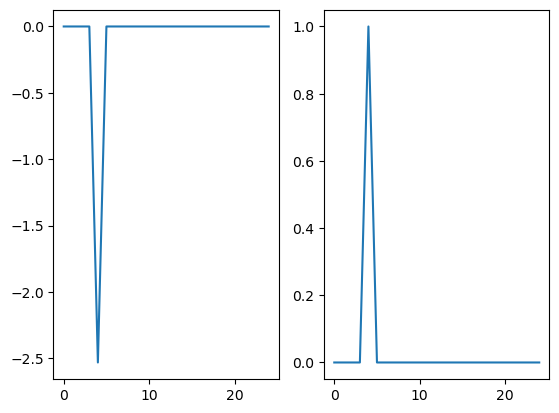

In [49]:
#plot on the same image he 2 images boarders_mask.loc[1,2015][200:400,675:750] bm.loc[1,2015][200:400,675:750]

plt.subplot(1,2,1)
plt.plot(bm.loc[1,2015][455:480,125])
plt.subplot(1,2,2)
plt.plot(boarders_mask.loc[1,2015][455:480,125])


In [50]:
#check o see that is actually maing the substitution
bm.loc[1,2015][455:480,125]

array([ 0.      ,  0.      ,  0.      ,  0.      , -2.531261,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ], dtype=float32)

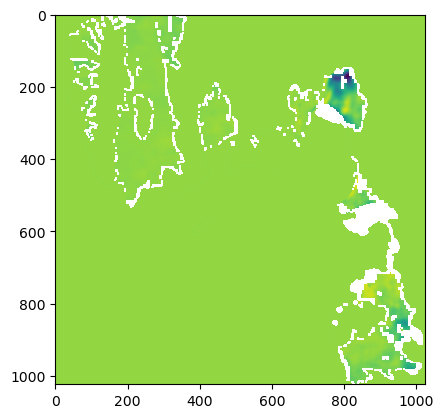

In [51]:
plt.imshow(bm.loc[1,2015])

In [52]:
#make the interpolation

from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

interpolated_values = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    print(id)
    for year in common_years:

        bm_nan = np.where(np.isnan(bm.loc[id,year]))
        bm_not_nan = np.where(~np.isnan(bm.loc[id,year]))

        bm_values = bm.loc[id,year][bm_not_nan]

        interpolated_values.loc[id,year] = griddata(
            bm_not_nan, bm_values, bm_nan, method='linear')

1


In [53]:
#Substitute the values where i interpolated

bm_interpolated = bm.copy() #store the values where i interpolated

for id in df.index:
    for year in common_years:

        nan_indices = np.isnan(bm_interpolated.loc[id,year])
        bm_interpolated.loc[id,year][nan_indices] = interpolated_values.loc[id,year]
        bm_interpolated.loc[id,year] = np.where(ice_mask.loc[id,year] == True, bm_interpolated.loc[id,year], np.nan)


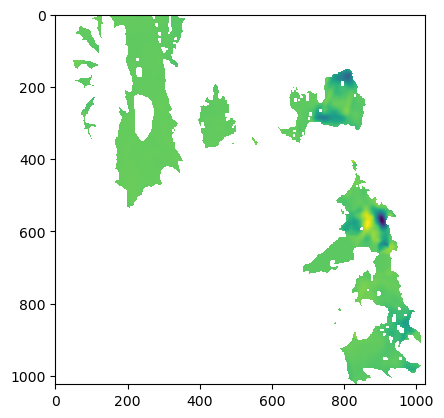

In [54]:
plt.imshow(bm_interpolated.loc[1,2006])

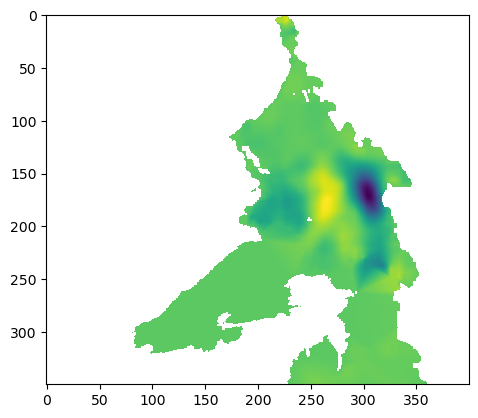

In [55]:
plt.imshow(bm_interpolated.loc[1,2006][400:750,600:1000])